In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from counterfactuals.cf_methods.ppcefr import PPCEFR
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import LinearRegression
from counterfactuals.losses import ThresholdRegressionLoss

In [26]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LinearRegression

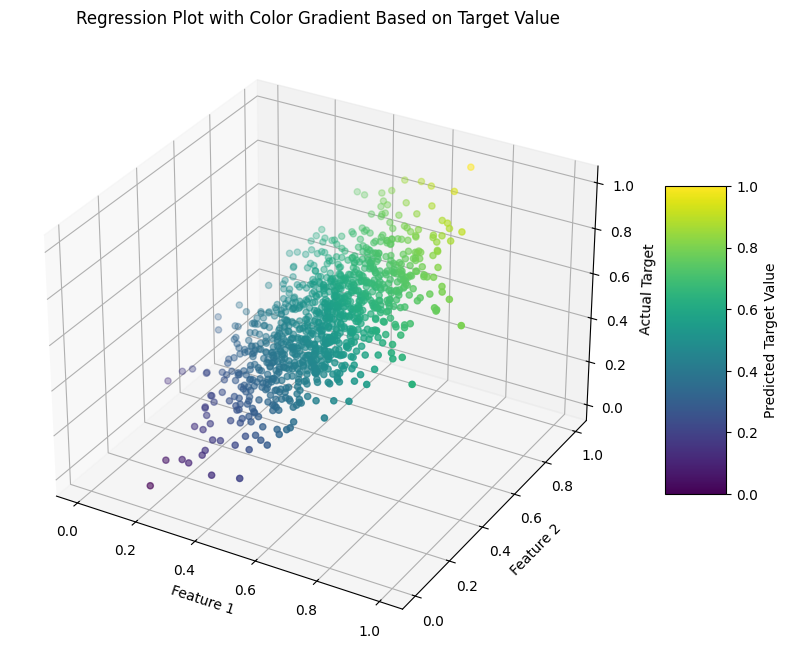

In [27]:
X_large, y_large = make_regression(
    n_samples=1000, n_features=2, noise=0.1, random_state=32
)
X = MinMaxScaler().fit_transform(X_large)
y = MinMaxScaler().fit_transform(y_large.reshape(-1, 1)).reshape(-1)

# Plotting the dataset with predictions and a color gradient based on the target value
fig_prediction = plt.figure(figsize=(10, 8))
ax_prediction = fig_prediction.add_subplot(111, projection="3d")

# Scatter plot using the actual test data and coloring based on predicted target values
scatter = ax_prediction.scatter(X[:, 0], X[:, 1], y, c=y, cmap="viridis", marker="o")

# Adding color bar to indicate the scale of the target values
cbar = fig_prediction.colorbar(scatter, ax=ax_prediction, shrink=0.5, aspect=5)
cbar.set_label("Predicted Target Value")

ax_prediction.set_xlabel("Feature 1")
ax_prediction.set_ylabel("Feature 2")
ax_prediction.set_zlabel("Actual Target")

plt.title("Regression Plot with Color Gradient Based on Target Value")
plt.show()

In [28]:
# # Plotting the dataset with predictions and adding the linear regression plane
# fig_with_plane = plt.figure(figsize=(10, 8))
# ax_with_plane = fig_with_plane.add_subplot(111, projection="3d")

# # Creating grid for the regression plane
# x_grid, y_grid = np.meshgrid(
#     np.linspace(min(X_test[:, 0]), max(X_test[:, 0]), 20),
#     np.linspace(min(X_test[:, 1]), max(X_test[:, 1]), 20),
# )
# # Predicting over the grid to plot the plane
# z_grid = lr_model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)

# # Plotting the regression plane
# ax_with_plane.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap="coolwarm")

# # Scatter plot using the actual test data with a color gradient
# scatter = ax_with_plane.scatter(
#     X_test[:, 0], X_test[:, 1], y_test, c=y_pred_test, cmap="viridis", marker="o"
# )

# # Adding color bar to indicate the scale of the target values
# cbar = fig_with_plane.colorbar(scatter, ax=ax_with_plane, shrink=0.5, aspect=5)
# cbar.set_label("Predicted Target Value")

# ax_with_plane.set_xlabel("Feature 1")
# ax_with_plane.set_ylabel("Feature 2")
# ax_with_plane.set_zlabel("Actual Target")

# plt.title("3D Regression Plot with Prediction Plane and Color Gradient")
# plt.show()

In [29]:
import torch.utils
import torch.utils.data


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    ),
    batch_size=1024,
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    ),
    batch_size=1024,
    shuffle=False,
)

In [30]:
disc_model = LinearRegression(2, 1)
disc_model.fit(train_dataloader, test_dataloader, epochs=2000, lr=0.003)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1999, Train Loss: 0.0000, Test Loss: 0.0000, Patience: 0: 100%|██████████| 2000/2000 [00:08<00:00, 244.03it/s]


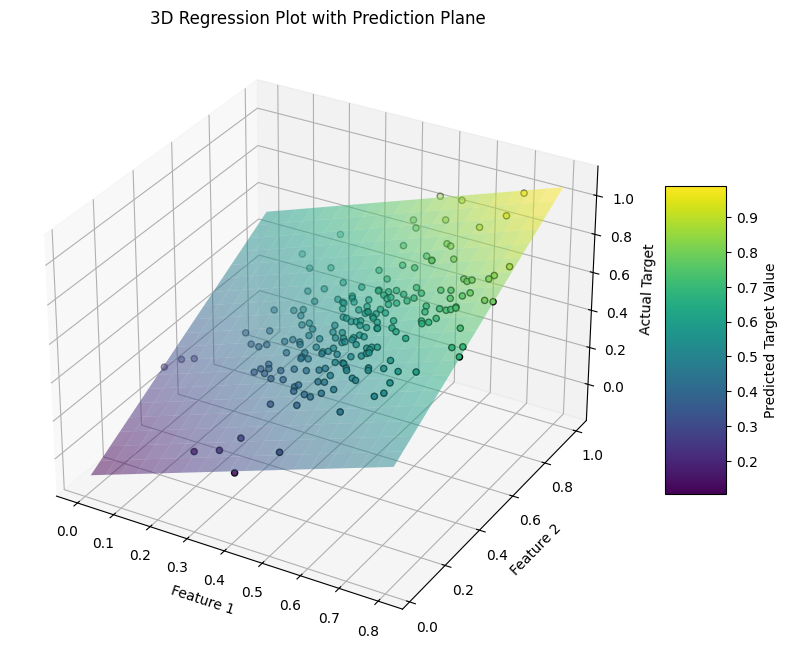

In [31]:
# Plotting the dataset with predictions and adding the linear regression plane
fig_with_plane = plt.figure(figsize=(10, 8))
ax_with_plane = fig_with_plane.add_subplot(111, projection="3d")

# Creating grid for the regression plane
x_grid, y_grid = np.meshgrid(
    np.linspace(min(X_test[:, 0]), max(X_test[:, 0]), 20),
    np.linspace(min(X_test[:, 1]), max(X_test[:, 1]), 20),
)
# Predicting over the grid to plot the plane
z_grid = disc_model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)

# Plotting the regression plane
ax_with_plane.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap="viridis")

y_pred_test = disc_model.predict(X_test)

# Scatter plot using the actual test data with a color gradient
scatter = ax_with_plane.scatter(
    X_test[:, 0],
    X_test[:, 1],
    y_test,
    c=y_pred_test,
    cmap="viridis",
    marker="o",
    edgecolors="black",
)

# Adding color bar to indicate the scale of the target values
cbar = fig_with_plane.colorbar(scatter, ax=ax_with_plane, shrink=0.5, aspect=5)
cbar.set_label("Predicted Target Value")

ax_with_plane.set_xlabel("Feature 1")
ax_with_plane.set_ylabel("Feature 2")
ax_with_plane.set_zlabel("Actual Target")

plt.title("3D Regression Plot with Prediction Plane")
plt.show()

In [32]:
def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X)
    y = torch.stack(y)

    # Add Gaussian noise to train features
    X = X + (torch.randn_like(X) * 0.03)

    # Add Gaussian noise to train labels
    y = y + (torch.randn_like(y) * 0.03)
    return X, y


gen_train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
    ),
    batch_size=1024,
    shuffle=True,
    collate_fn=collate_fn,
)

In [33]:
# train_dataloader = dataset.train_dataloader(batch_size=256, shuffle=True, noise_lvl=0.003)
# test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model = MaskedAutoregressiveFlow(
    features=2,
    hidden_features=8,
    num_layers=2,
    num_blocks_per_layer=2,
    context_features=1,
)
gen_model.fit(
    gen_train_dataloader,
    test_dataloader,
    num_epochs=3000,
    patience=200,
    learning_rate=0.001,
)

Epoch 1443, Train: -2.1165, test: -2.7148, patience: 200:  48%|████▊     | 1443/3000 [00:09<00:10, 146.40it/s]


In [34]:
xline = torch.linspace(-0.25, 1.25, 200)
yline = torch.linspace(-0.25, 1.25, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

In [35]:
# with torch.no_grad():
#     ys = torch.fill_(torch.zeros_like(xyinput[:, 0]), 0.6)
#     zgrid = gen_model(xyinput, ys).exp().reshape(200, 200)
# zgrid = zgrid.numpy()
# plt.contour(
#     xgrid.numpy(),
#     ygrid.numpy(),
#     zgrid,
#     levels=10,
#     cmap="Greys",
#     linewidths=0.4,
#     antialiased=True,
# )

# median_log_prob =

# prob_threshold_exp = np.exp(median_log_prob)
# plt.contourf(
#     xgrid.numpy(),
#     ygrid.numpy(),
#     zgrid,
#     levels=[prob_threshold_exp, prob_threshold_exp * 10.00],
#     alpha=0.5,
#     colors="#DC143C",
# )  # 10.00 is an arbitrary huge value to colour the whole distribution.
# # plt.scatter(X_train[:, 0], y_train, c="blue", alpha=0.1)

In [73]:
cf = PPCEFR(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=ThresholdRegressionLoss(),
    neptune_run=None,
)
# median_log_prob = torch.median(gen_model.predict_log_prob(test_dataloader))

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    ),
    batch_size=1024,
    shuffle=False,
)

median_log_prob = torch.quantile(gen_model.predict_log_prob(train_dataloader), 0.25)
median_log_prob

X_cf, X_orig, y_orig, y_target, losses = cf.search_batch(
    cf_dataloader,
    alpha=1000,
    delta=median_log_prob,
    target=0.2,
    patience=300,
    epochs=5000,
)
# print(X_cf)

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


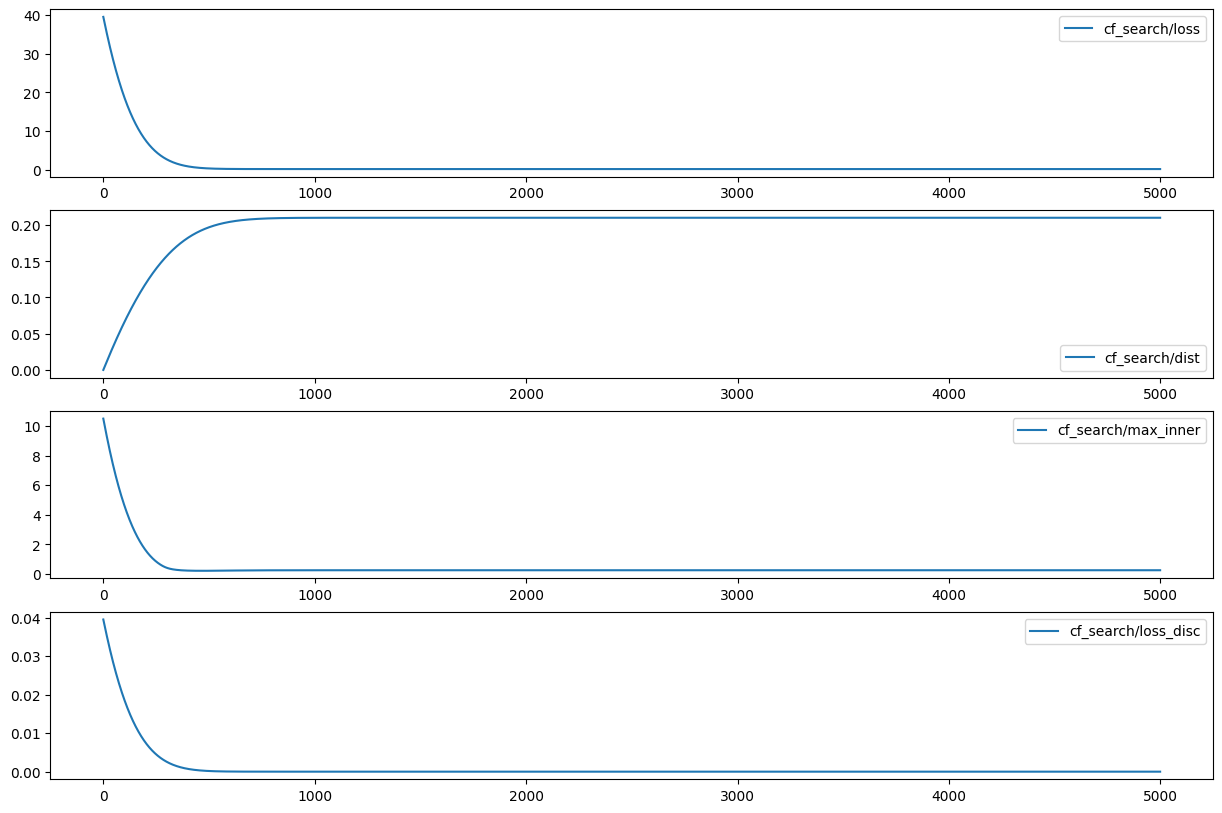

In [74]:
plt.figure(figsize=(15, 10))
for i, (loss_name, loss_values) in enumerate(losses.items()):
    plt.subplot(len(losses), 1, i + 1)
    plt.plot(loss_values, label=loss_name)
    plt.legend()

In [59]:
np.mean(np.abs(disc_model.predict(X_cf).numpy() - y_target.reshape(-1)))

0.0005302141

In [60]:
np.mean(np.abs(disc_model.predict(X_orig).numpy() - y_target))

0.23596902

In [61]:
(
    gen_model(torch.from_numpy(X_cf), torch.from_numpy(y_target)) > median_log_prob
).float().mean()

tensor(0.6550)

/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_37498/3958498841.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_with_plane.scatter(


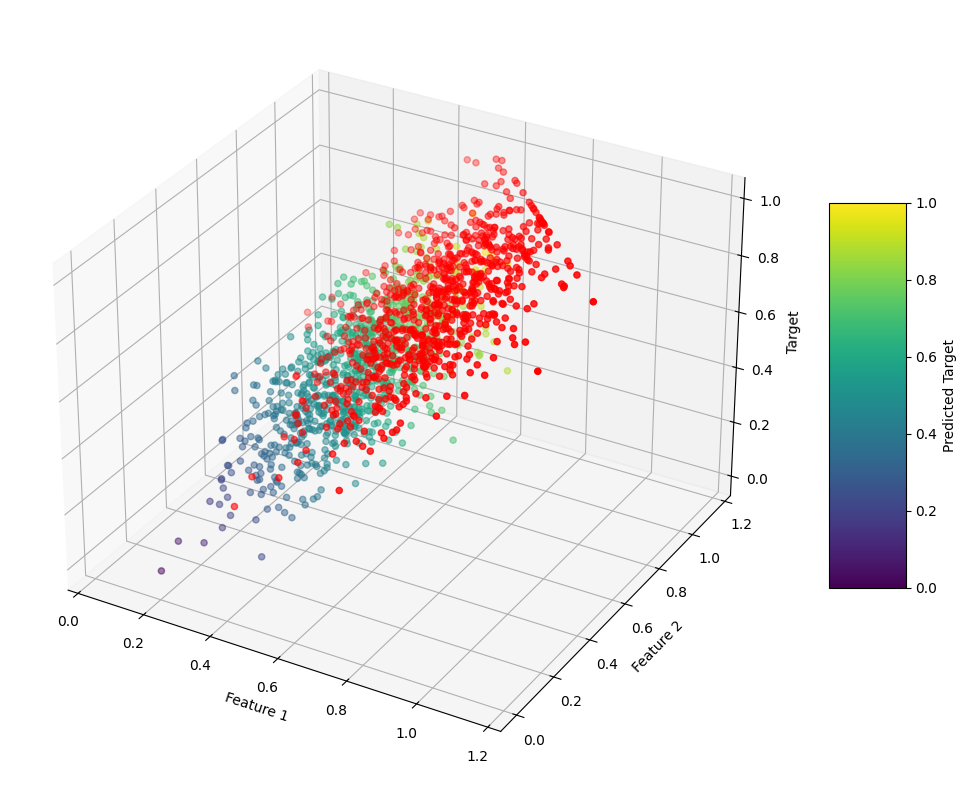

In [62]:
# Plotting the dataset with predictions and adding the linear regression plane
fig_with_plane = plt.figure(figsize=(10, 8))
ax_with_plane = fig_with_plane.add_subplot(111, projection="3d")

# Creating grid for the regression plane
x_grid, y_grid = np.meshgrid(
    np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), 20),
    np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), 20),
)
# Predicting over the grid to plot the plane
z_grid = disc_model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)

# Plotting the regression plane
# ax_with_plane.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap='coolwarm')

y_cf_pred = disc_model.predict(X_cf)

# Scatter plot using the actual test data with a color gradient
scatter = ax_with_plane.scatter(
    X_train[:, 0],
    X_train[:, 1],
    y_train,
    c=y_train,
    cmap="viridis",
    marker="o",
    alpha=0.5,
)
scatter = ax_with_plane.scatter(
    X_cf[:, 0], X_cf[:, 1], y_cf_pred, c="red", cmap="viridis", marker="o"
)

# Adding color bar to indicate the scale of the target values
cbar = fig_with_plane.colorbar(scatter, ax=ax_with_plane, shrink=0.5, aspect=5)
cbar.set_label("Predicted Target")

ax_with_plane.set_xlabel("Feature 1")
ax_with_plane.set_ylabel("Feature 2")
ax_with_plane.set_zlabel("Target")

# plt.title("3D Regression Plot with Prediction Plane and Color Gradient")
# plt.show()
plt.tight_layout()
plt.savefig("wach_example.pdf", dpi=300)

In [53]:
np.quantile(gen_model.predict_log_prob(train_dataloader), 0.25)

2.5106531381607056

/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_37498/4223399064.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(z_grid.ravel(), dtype=torch.float32),


(10, 2) (10,) (10, 2) torch.Size([10])


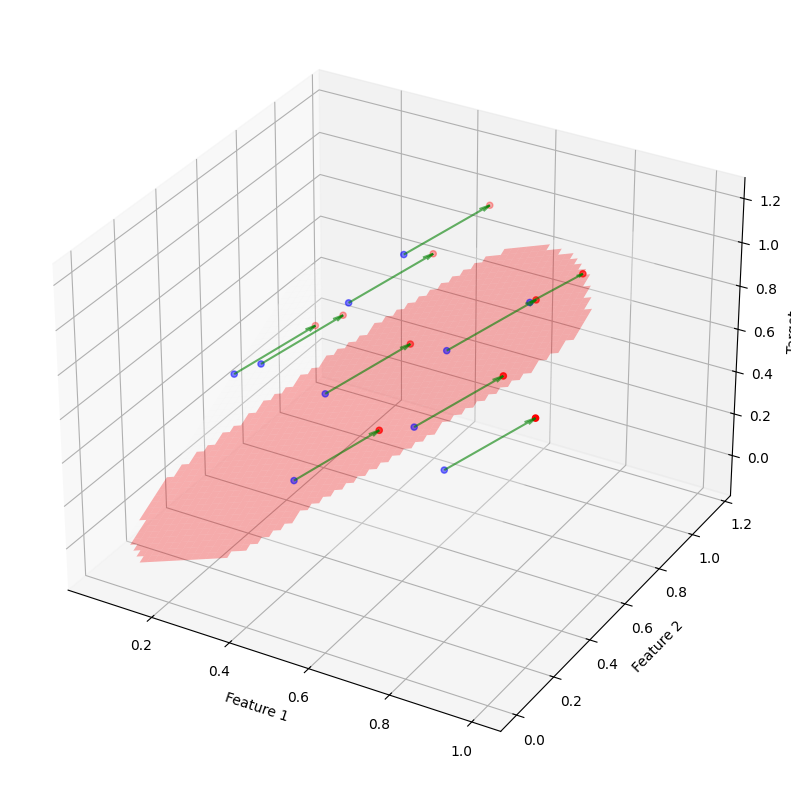

In [63]:
# Plotting the dataset with predictions and adding the linear regression plane
fig_with_plane = plt.figure(figsize=(10, 8))
ax_with_plane = fig_with_plane.add_subplot(111, projection="3d", computed_zorder=False)

# Creating grid for the regression plane
x_grid, y_grid = np.meshgrid(
    np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), 200),
    np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), 200),
)
# Predicting over the grid to plot the plane
z_grid = disc_model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)
color_grid = (
    gen_model(
        torch.tensor(np.c_[x_grid.ravel(), y_grid.ravel()], dtype=torch.float32),
        torch.tensor(z_grid.ravel(), dtype=torch.float32),
    )
    .numpy()
    .reshape(x_grid.shape)
)

delta = np.quantile(color_grid.ravel(), 0.5)

colors = np.empty(color_grid.shape + (4,), dtype=float)
alpha_below = 0.0  # Transparency for values below threshold
alpha_above = 1.0  # Opacity for values above threshold

colors[color_grid < delta] = [1, 1, 1, alpha_below]  # Below threshold, transparent
colors[color_grid >= delta] = [1, 0, 0, alpha_above]  # Above threshold, red


surf = ax_with_plane.plot_surface(
    x_grid, y_grid, z_grid, alpha=0.3, facecolors=colors, edgecolor="none"
)
ax_with_plane.set_xlabel("Feature 1")
ax_with_plane.set_ylabel("Feature 2")
ax_with_plane.set_zlabel("Target")


y_cf_pred = disc_model.predict(X_cf)

# i_points = np.array([0,1,7,12,16, 23, 24, 30, 123, 199])

i_points_od = np.argwhere(
    gen_model(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    .exp()
    .detach()
    .numpy()
    < delta
).flatten()
i_points_id = np.argwhere(
    gen_model(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    .exp()
    .detach()
    .numpy()
    > delta
).flatten()

i_points = np.c_[
    np.random.choice(i_points_od, 5, replace=False),
    np.random.choice(i_points_id, 5, replace=False),
].flatten()
# print(gen_model(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)).exp().detach().numpy())
# raise

# i_points = np.random.choice(range(len(X_cf)), 10, replace=False)
X_points = X_train[i_points]
y_points = y_train[i_points]
X_cf_points = X_cf[i_points]
y_cf_pred_points = y_cf_pred[i_points]

print(X_points.shape, y_points.shape, X_cf_points.shape, y_cf_pred_points.shape)

# Scatter plot using the actual test data with a color gradient
scatter = ax_with_plane.scatter(
    X_points[:, 0],
    X_points[:, 1],
    y_points,
    c="b",
    # cmap="viridis",
    marker="o",
    alpha=0.5,
)
scatter = ax_with_plane.scatter(
    X_cf_points[:, 0],
    X_cf_points[:, 1],
    y_cf_pred_points,
    c="red",
    marker="o",  # cmap="viridis",
)

# Draw arrows from train points to cf points
for i in range(len(i_points)):
    ax_with_plane.quiver(
        X_points[i, 0],
        X_points[i, 1],
        y_points[i],
        X_cf_points[i, 0] - X_points[i, 0],
        X_cf_points[i, 1] - X_points[i, 1],
        y_cf_pred_points[i] - y_points[i],
        color="green",
        alpha=0.6,
        arrow_length_ratio=0.1,
    )


# # plt.title("3D Regression Plot with Prediction Plane and Color Gradient")
# plt.show()
plt.tight_layout()
# plt.savefig("wach_constrained.pdf", dpi=100)

In [119]:
X_train[[0, 1]]

array([[0.32973062, 0.78502098],
       [0.77892529, 0.24236651]])

In [120]:
y_train[[0, 1]]

array([0.60577032, 0.55243636])

# CEARM

In [68]:
# Define the EP potential function
def ep_potential(y, y_query, w=0.2):
    term = (y_query - y) / w
    z = np.maximum(term, 0)
    aep_p = z**2 * np.exp(-(z**2))
    # z = - np.minimum(term, 0)
    # aep_m = z ** 2 * np.exp(-(z**2))
    return aep_p
    # return (y - y_query)**2 * np.exp(-((y - y_query)**2) / w)


# Objective function for Bayesian Optimization
def objective_function(X_new, index):
    X_new = X_new.reshape(1, -1)
    y_query = disc_model.predict(
        X_train[index].reshape(1, -1)
    )  # Current prediction we want to change
    # print("Y_query: ", y_query)
    y_pred = disc_model.predict(X_new)
    # print("Y_PRED: ", y_pred)
    # print(y_pred)
    potential = ep_potential(y_query, y_pred)
    # print(f"Potential: {potential}")
    return potential

In [69]:
import GPyOpt
from tqdm import tqdm
# Generate counterfactuals for each test instance

counterfactuals = []

for i in tqdm(range(len(X_train))):
    domain = [
        {"name": f"var_{j}", "type": "continuous", "domain": (0, 1)}
        for j in range(X_train.shape[1])
    ]
    optimizer = GPyOpt.methods.BayesianOptimization(
        f=lambda X_new: objective_function(X_new, i),
        domain=domain,
        model_type="GP",
        acquisition_type="EI",
        normalize_Y=False,
        evaluator_type="thompson_sampling",
        maximize=True,
    )
    optimizer.run_optimization(eps=1e-3, max_iter=5)
    counterfactuals.append(optimizer.x_opt.reshape(1, -1))

# # Print some example counterfactual inputs
# print("Original vs Counterfactual for the first 5 test instances:")
# for i in range(2):
#     print(f"Original: {X_test[i]}, Counterfactual: {counterfactuals[i]}")

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [07:55<00:00,  1.68it/s]


In [70]:
X_cf = np.array(counterfactuals).reshape(-1, 2)

(10, 2) (10,) (10, 2) torch.Size([10])


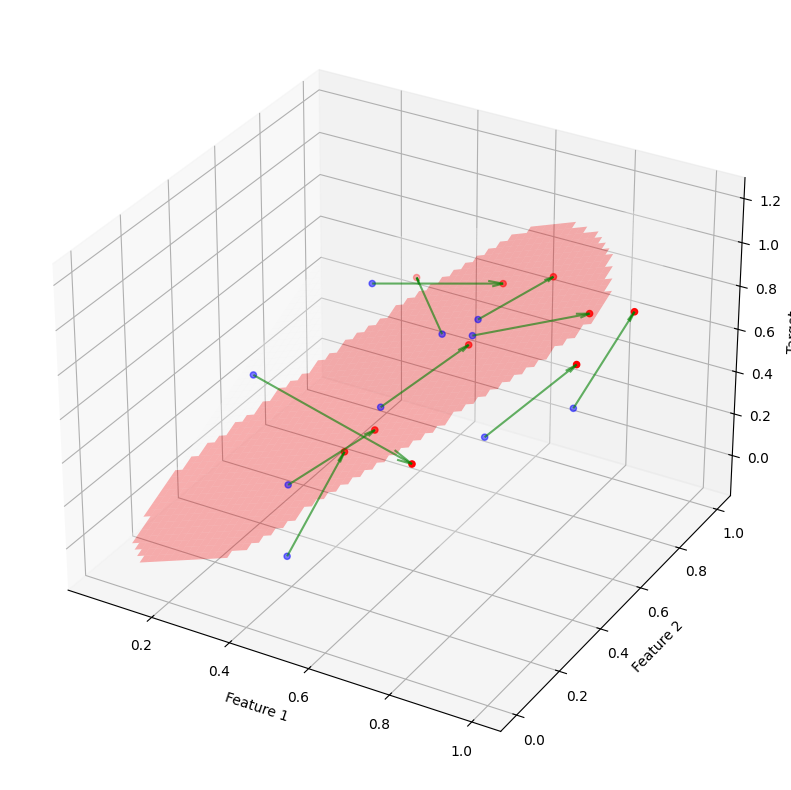

In [72]:
# Plotting the dataset with predictions and adding the linear regression plane
fig_with_plane = plt.figure(figsize=(10, 8))
ax_with_plane = fig_with_plane.add_subplot(111, projection="3d", computed_zorder=False)

# Creating grid for the regression plane
x_grid, y_grid = np.meshgrid(
    np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), 200),
    np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), 200),
)
# Predicting over the grid to plot the plane
z_grid = disc_model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)
color_grid = (
    gen_model(
        torch.tensor(np.c_[x_grid.ravel(), y_grid.ravel()], dtype=torch.float32),
        torch.tensor(z_grid.ravel(), dtype=torch.float32),
    )
    .numpy()
    .reshape(x_grid.shape)
)

delta = np.quantile(color_grid.ravel(), 0.5)

colors = np.empty(color_grid.shape + (4,), dtype=float)
alpha_below = 0.0  # Transparency for values below threshold
alpha_above = 1.0  # Opacity for values above threshold

colors[color_grid < delta] = [1, 1, 1, alpha_below]  # Below threshold, transparent
colors[color_grid >= delta] = [1, 0, 0, alpha_above]  # Above threshold, red


surf = ax_with_plane.plot_surface(
    x_grid, y_grid, z_grid, alpha=0.3, facecolors=colors, edgecolor="none"
)
ax_with_plane.set_xlabel("Feature 1")
ax_with_plane.set_ylabel("Feature 2")
ax_with_plane.set_zlabel("Target")


y_cf_pred = disc_model.predict(X_cf)

# i_points = np.array([0,1,7,12,16, 23, 24, 30, 123, 199])

i_points_od = np.argwhere(
    gen_model(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    .exp()
    .detach()
    .numpy()
    < delta
).flatten()
i_points_id = np.argwhere(
    gen_model(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )
    .exp()
    .detach()
    .numpy()
    > delta
).flatten()

i_points = np.c_[
    np.random.choice(i_points_od, 5, replace=False),
    np.random.choice(i_points_id, 5, replace=False),
].flatten()
# print(gen_model(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)).exp().detach().numpy())
# raise

# i_points = np.random.choice(range(len(X_cf)), 10, replace=False)
X_points = X_train[i_points]
y_points = y_train[i_points]
X_cf_points = X_cf[i_points]
y_cf_pred_points = y_cf_pred[i_points]

print(X_points.shape, y_points.shape, X_cf_points.shape, y_cf_pred_points.shape)

# Scatter plot using the actual test data with a color gradient
scatter = ax_with_plane.scatter(
    X_points[:, 0],
    X_points[:, 1],
    y_points,
    c="b",
    # cmap="viridis",
    marker="o",
    alpha=0.5,
)
scatter = ax_with_plane.scatter(
    X_cf_points[:, 0],
    X_cf_points[:, 1],
    y_cf_pred_points,
    c="red",
    marker="o",  # cmap="viridis",
)

# Draw arrows from train points to cf points
for i in range(len(i_points)):
    ax_with_plane.quiver(
        X_points[i, 0],
        X_points[i, 1],
        y_points[i],
        X_cf_points[i, 0] - X_points[i, 0],
        X_cf_points[i, 1] - X_points[i, 1],
        y_cf_pred_points[i] - y_points[i],
        color="green",
        alpha=0.6,
        arrow_length_ratio=0.1,
    )


# # plt.title("3D Regression Plot with Prediction Plane and Color Gradient")
# plt.show()
plt.tight_layout()
# plt.savefig("cearm_constrained.pdf", dpi=100)